# <font color=#2e86c1> $R_{1\rho}$ simulation and analysis</font> 

<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/JupyterBook/ssNMR2025/R1p_COLAB.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The $R_{1\rho}$ experiment is a useful experiment for characterizing slow ($\mu$s/ms) motion in solid-state NMR. The pulse sequence involves flipping magnetization of a spin (often $^{15}$N or $^{13}$C, CP-based excitation also possible) to the x-axis, spin-locking that magnetization, and observing its decay (again, CP-transfer back to $^1$H may be useful).

<img src="R1p_sequence.png" alt="sequence" width=300>

This experiment is sensitive to both reorientational motion of anisotropic tensors (dipole/CSA) and changes to the isotropic chemical shift. In the first part of this exercise, we will use simulation to explore the relaxation behavior of the $R_{1\rho}$ experiment, and in the second part, we will fit $R_{1\rho}$ measurements to extract dynamics parameters from a data set.

## Part 1: Simulating $R_{1\rho}$
Relaxation can be simulated by creating a spin system that exchanges between two states stochastically, thereby inducing various relaxation processes. For $R_{1\rho}$, we simply need to use such a system with a spin-lock on one of the spins. Below, we set up the SLEEPY code for a basic $R_{1\rho}$ experiment.

### Python Setup
If SLEEPY is not already installed (e.g. if working in Google Colab), then we need to install it. We then need to import the SLEEPY module, as well as numpy which has a lot of linear algebra and other mathematical tools, and matplotlib, which is used to create figures. We also turn off messages from SLEEPY.

In [1]:
# Make sure SLEEPY is installed and on the path
import sys
import os
sys.path.append('/Users/albertsmith/Documents/GitHub/')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')

In [2]:
import sys
if 'google.colab' in sys.modules: #Colab
    !pip install sleepy-nmr
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
sl.Defaults['verbose']=False

### Simulation Setup
Setup contains similar parameters as SIMPSON, with an important distinction: we set up the system
twice (ex0,ex1) with different Euler angles, to introduce reorientational motion, and with a different chemical shift, to introduce chemical exchange.

Reorientational motion is introduced by putting a dipole and/or CSA into both ex0 and ex1, with the same coupling size, but with a different set of Euler angles (usually introduced on the beta angle). Here, we use both the dipole and CSA as would be typical for $^{15}$N in the protein backbone.

Chemical exchange is introduced by including a chemical shift that changes value between ex0 and ex1.

Note that this setup means reorientation and chemical exchange are simultaneous processes.

#### Parameters

In [3]:
# H-N dipole coupling for 0.102 nm
# Note, this value is the dipole anisotropy,
# which is twice the size of the coupling given in SIMPSON
deltaHN=sl.Tools.dipole_coupling(.102,'1H','15N')
# Typical protein backbone 15N CSA
deltaCSA=113
# Change in the 15N chemical shift
DelCS=10
# Hop angle
hop_angle=25
# Correlation time of the exchange
tc=1e-5
# Population of state 1
p1=0.5
# Spin-lock strength
v1=35000

#### Build the experimental systems

In [4]:
# Magnetic field (MHz), Nuclei, spinning rate, powder-average quality
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30)
# H–N dipole coupling, i0: spin 0, i1: spin 1, delta: anisotropy of interaction
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
# 15N CSA, i: spin, delta: anisotropy in ppm, euler_d: Euler angles in degrees
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])
# 15N chemical shift, i: spin, CS: chemical shift in ppm
ex0.set_inter('CS',i=0,ppm=DelCS/2)

# Copy ex0 (links copies, ensures matching experimental settings)
ex1=ex0.copy()
# As above, plus tilt the dipole coupling by the hop_angle
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
# As above, plus add a second set of Euler angles with the hop angle
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])
# As above, but change CS
_=ex1.set_inter('CS',i=0,ppm=-DelCS/2)  # _ captures the output, reducing clutter

#### Couple systems into a Liouvillian, generate a pulse sequence

In [5]:
# Create a Liouvillian with two systems in exchange
L=sl.Liouvillian(ex0,ex1)
# Add an exchange matrix betweent the two systems
L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)

# Create a pulse sequence object
seq=L.Sequence()
# Add a spin-locking field 
# For continuous field, we can just specify power
# but including a time axis with varying power, phase, and offset is also possible
_=seq.add_channel('15N',v1=v1)
# Note that the default sequence length is 1 rotor period if the time axis is not given

#### Create a density matrix, propagate

In [6]:
# Initial state of density matrix, detection matrix
rho=sl.Rho(rho0='15Nx',detect='15Nx')
# Propagate for 100 ms (n is number of steps, use int() to get an integer)
_=rho.DetProp(seq,n=int(0.1*ex0.vr)) 

### Plot the results

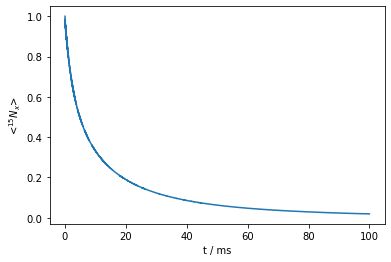

In [7]:
_=rho.plot()

### Create functions for faster setup
If we want to repeat calculations under varying conditions, it can be easier to wrap the setup up in a function, and then we can just call that function later. Two functions are generated here:

* R1pU : Propagator for 1 rotor period. Optionally adjust correlation time (tc, s), populations (p1), hop angle (hop_angle, degrees), size of chemical exchange (DelCS, ppm), applied field strength (v1, Hz).

* R1p_rho : Density matrix, propagated for 100 ms. Same arguments as R1pU.

There's not much new in terms of SLEEPY in the code below. Skip over, or read more carefully if you're interested in how to setup a function in Python.

In [8]:
def R1pU(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1,gamma=120):
    ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30)
    if hop_angle:
        ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,-hop_angle/2,0])
        ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,gamma],[0,-hop_angle/2,0]])
    ex0.set_inter('CS',i=0,ppm=DelCS/2)
    
    ex1=ex0.copy()
    if hop_angle:
        ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle/2,0])
        ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,gamma],[0,hop_angle/2,0]])
    ex1.set_inter('CS',i=0,ppm=-DelCS/2)

    L=sl.Liouvillian(ex0,ex1)
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    seq=L.Sequence(Dt=1/60000)
    seq.add_channel('15N',v1=v1)
    return seq.U()

def R1p_rho(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1):
    U=R1pU(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1)
    rho=sl.Rho(rho0='15Nx',detect='15Nx')
    rho.DetProp(U**int(U.expsys.vr/1000),n=100)
    return rho

### Examine relaxation for various conditions

1. High spin-lock strength (35 kHz)

   We'll first calculate relaxation with both reorientational dynamics and chemical exchange. Then, we'll calculate each process separately to see which dominates the relaxation at this field strength. 

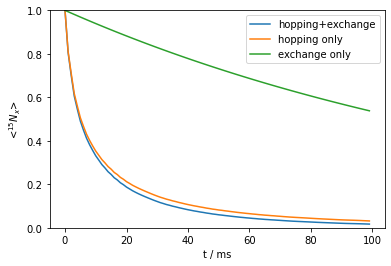

In [9]:
v1=35000
rho=R1p_rho(v1=v1)
rho_hop=R1p_rho(v1=v1,DelCS=0) #Sets the chemical exchange to 0
rho_ex=R1p_rho(v1=v1,hop_angle=0) #Sets the reorientational motion to 0

ax=rho.plot(label='hopping+exchange')   #plot returns an axis, which we can use for the subsequent plots
rho_hop.plot(ax=ax,label='hopping only') #Now use ax as an argument
rho_ex.plot(ax=ax,label='exchange only')

ax.set_ylim([0,1])  #Make the axis go down to 0
_=ax.legend()  #Show a legend with the labels given above

**Q:** At 35 kHz, what is the dominant relaxation process, reorientational dynamics, or chemical exchange?
```{dropdown} Answer
Relaxation due to reorientation is much faster, where removing exchange has only a minor impact on the relaxation curve.
```

2. Low spin-lock strength (4 kHz)

   We repeat the above calculation, but with only 4 kHz spin-lock.

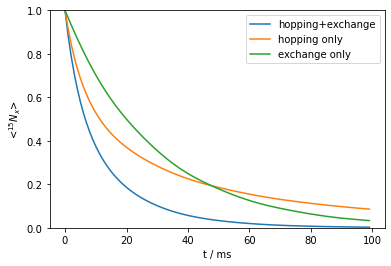

In [13]:
v1=4000
rho=R1p_rho(v1=v1)
rho_hop=R1p_rho(v1=v1,DelCS=0) #Sets the chemical exchange to 0
rho_ex=R1p_rho(v1=v1,hop_angle=0) #Sets the reorientational motion to 0

ax=rho.plot(label='hopping+exchange')   #plot returns an axis, which we can use for the subsequent plots
rho_hop.plot(ax=ax,label='hopping only') #Now use ax as an argument
rho_ex.plot(ax=ax,label='exchange only')

ax.set_ylim([0,1])  #Make the axis go down to 0
ax.legend()  #Show a legend with the labels given above

**Q:** Compare the curves for hopping only and exchange only. Why do the curves cross?
```{dropdown} Answer
The initial decay from hopping is faster, but by the end of the plot, more decay has occurred for exchange. The curves cross because the exchange process yields a monoexponentially decaying signal, whereas the hopping process yields multiexponential decay.
```

#### Sources of multiexpontiality

**Q:** Above, we noticed that hopping yields multiexponential decay. Give one reason for the multiexponential decay (there are actually two sources, but we start with the one that is more obvious to me)
```{dropdown} Answer
The first reason is that different elements of the powder average relax with different rate constants. SLEEPY lets us plot individual elements of the powder average, so let's check if relaxation becomes monoexponential! (reveal hidden cell below)
```

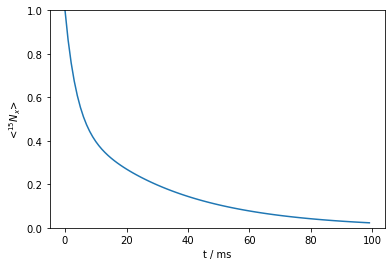

In [14]:
pwd_index=5
ax=rho_hop.plot(pwd_index=pwd_index)     #pwd_index specifies which element of the powder element to display
_=ax.set_ylim([0,1]) #Adjust the y-axis

**Q:** So, the curve is still bi-exponential. Then, what is the second reason for multi-exponentiality?
*Hint: What interactions undergo reorientational motion?*
```{dropdown} Answer
Both the CSA and dipole coupling are undergoing reorientational dynamics. Then, depending if the $^1$H is spin-up or spin-down, the CSA/dipole relaxation will be additive or subtractive, yielding different relaxation rates. Reveal the cell below, where we separate the $^1$H spin-up (alpha) and spin-down (beta) states.
```

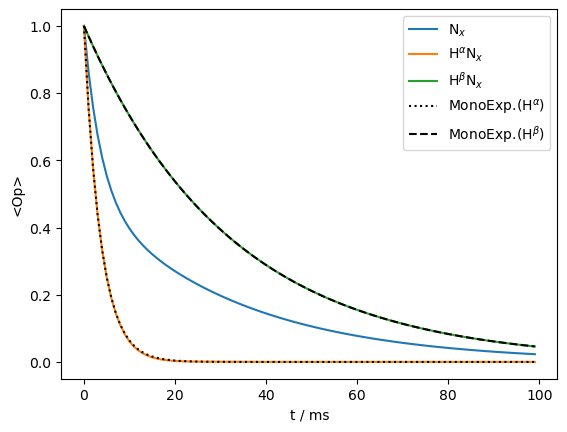

In [13]:
#ex0.Op are the spin-operator matrices.
#Index for the desired spin and then get x,y,z,p(+),m(-),alpha, or beta matrices
#Use the @ symbol for matrix multiplication
HalphaNx=ex0.Op[0].x@ex0.Op[1].alpha
HbetaNx=ex0.Op[0].x@ex0.Op[1].beta
U=R1pU(v1=v1,DelCS=0)
rho=sl.Rho(rho0='15Nx',detect=['15Nx',HalphaNx,HbetaNx])

# Here we extract the decay rates (A little tricky)
# We need to grab the right element of the powder average ([pwd_avg]),
# which then still has a very fast decaying, but low weighted term
# and a slow decay term, which is the relevant one (.min())
rates,*_=rho.clear().extract_decay_rates(U,det_num=1,mode='rates')
Ralpha=rates[pwd_index].min()
rates,*_=rho.clear().extract_decay_rates(U,det_num=2,mode='rates')
Rbeta=rates[pwd_index].min()

rho.DetProp(U**60,n=100)
ax=rho.plot(pwd_index=5,det_num=0,label=r'N$_x$')
rho.plot(pwd_index=5,det_num=1,label=r'H$^\alpha$N$_x$',ax=ax)
rho.plot(pwd_index=5,det_num=2,label=r'H$^\beta$N$_x$',ax=ax)

ax.plot(rho.t_axis*1e3,np.exp(-rho.t_axis*Ralpha),linestyle=':',color='black',label=r'MonoExp.(H$^\alpha$)')
ax.plot(rho.t_axis*1e3,np.exp(-rho.t_axis*Rbeta),linestyle='--',color='black',label=r'MonoExp.(H$^\beta$)')

_=ax.legend()

Then, we see that for a single orientation, and single state of the $^1$H, we do indeed get monoexponential relaxation.

### Field strength and correlation time dependence of $R_{1\rho}$

When we characterize motion using $R_{1\rho}$ relaxation, we often acquire a field-strength profile, which can then be used to estimate amplitude and correlation time of motion. We simulate such a profile below.

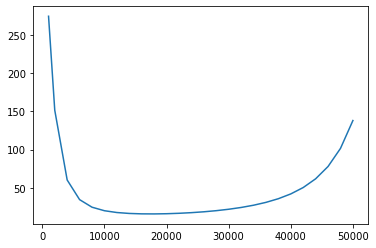

In [15]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
v10=np.linspace(0,50000,26)
v10[0]=1000
R1p=[]
for v1 in v10:
    rho.clear()
    U=R1pU(tc=1e-4,v1=v1,gamma=0)
    R1p.append(rho.extract_decay_rates(U))
    
ax=plt.subplots()[1]
_=ax.plot(v10,R1p)

To understand how $R_{1\rho}$ depends timescale of motion, we similarly sweep correlation time and calculate $R_{1\rho}$ for $v_1$=35 kHz.

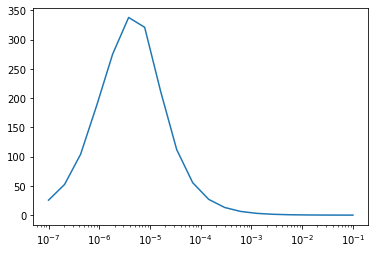

In [24]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
tc0=np.logspace(-7,-1,20)
ax=plt.subplots()[1]
hop_angle=30
R1p=[]
for tc in tc0:
    rho.clear()
    U=R1pU(tc=tc,v1=35000,hop_angle=hop_angle)
    R1p.append(rho.extract_decay_rates(U))
_=ax.semilogx(tc0,R1p,label=fr'hop angle = {hop_angle} $^\circ$')

**Q:** We repeat the above simulation, but adjust the applied field to a much lower field strength.
What changes in the result profile, and why?
```{dropdown} Answer
A second peak appears at longer correlation times. The lower applied field increases the contribution to relaxation coming from chemical exchange vs. reorientation motion. Then, a second peak appears around $\tau_c=1/(2\pi\v_1)$, where the high, 35 kHz field in the first example suppressed this peak.
```

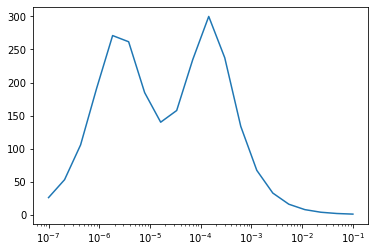

In [25]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
tc0=np.logspace(-7,-1,20)
ax=plt.subplots()[1]
hop_angle=30
R1p=[]
for tc in tc0:
    rho.clear()
    U=R1pU(tc=tc,v1=1000,hop_angle=hop_angle)
    R1p.append(rho.extract_decay_rates(U))
_=ax.semilogx(tc0,R1p,label=fr'hop angle = {hop_angle} $^\circ$')

## Bonus: Edit the following code to simulate T$_1$ relaxation instead of T$_{1\rho}$
*Hints:*

1. $T_{1\rho}$ can be simulated in the rotating frame, but $T_1$ requires non-secular terms which only appear in the lab frame
2. No applied field is required for $T_1$ relaxation
3. $T_1$ relaxation is sensitive to faster motions than $T_{1\rho}$ relaxation (~ns)
4. $T_1$ addresses z-magnetization,not x-magnetization (you can also use multiple detection matrices in SLEEPY in a list, i.e. use [] brackets, so consider also seeing what $^1$H magnetization is doing.
5. $T_1$ occurs on a longer timescale  than $T_{1\rho}$

<Axes: xlabel='t / ms', ylabel='<$^{15}N_x$>'>

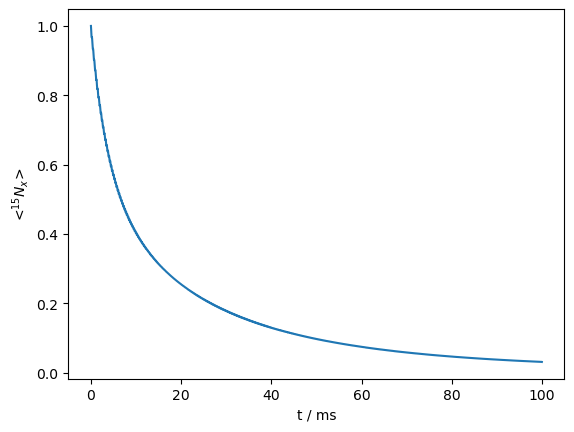

In [21]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30,LF=False)
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])

ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-6,p1=p1)

seq=L.Sequence()
seq.add_channel('15N',v1=v1)

# Initial state of density matrix, detection matrix
rho=sl.Rho(rho0='15Nx',detect='15Nx')
# Propagate for 100 ms (n is number of steps, use int() to get an integer)
rho.DetProp(seq,n=6000) 
rho.plot()

<Axes: xlabel='t / s', ylabel='<Op>'>

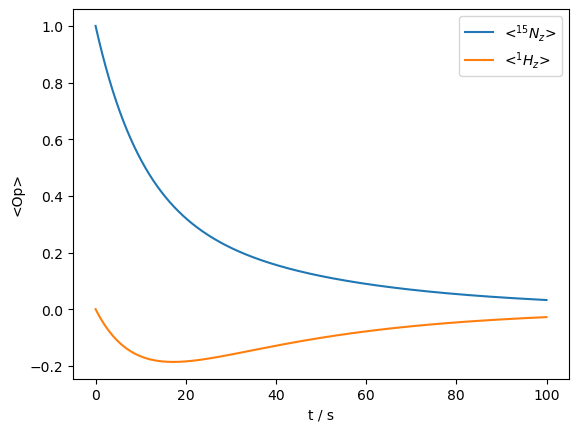

In [25]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30,LF=True)
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])

ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-10,p1=p1)

seq=L.Sequence()

# Initial state of density matrix, detection matrix
rho=sl.Rho(rho0='15Nz',detect=['15Nz','1Hz'])
# Propagate for 100 ms (n is number of steps, use int() to get an integer)
rho.DetProp(seq**1000,n=6000) 
rho.plot()

## Part 2: Fitting Bloch-McConnell Relaxation Dispersion Data


The above discussion has dealt with the simulation of dispersion data: where we have a model for our system, and would like to predict the dispersion profiles arising from this. Now, we consider the inverse problem. 

Experimentally, we may record relaxation dispersion profiles. However, these dispersion profiles do not directly tell us much about our system. For this, we'd like some way of being able to model these. Firstly, some experimental considerations:

* Strong anisotropic interactions in the solid state restrict our lowest $\nu_1$ RF field strength to $\approx$ 2 kHz.
* Proton-driven spin diffusion requires that we consider the MAS frequencies and isotopic labelling we apply.
* We need to consider possible recoupling conditions which may lead to artefactual elevation in BMRD profiles - for this reason, it is important to consider decoupling the $^{1}$H channel.

Before we move on to analysing the dispersion curves, it may be useful to play around with the dispersion model you've been using above to see how the form of this curve varies with the difference in chemical shift, populations, and correlation times.

### Formulas for relaxation behavior
The relaxation that was simulated above can be calculated using formulas. For reorientational motion, we typically calculate the orientationally-averaged relaxation rate constant. For exchange, there is no orientation dependence, so the formula simply returns the relaxation rate constant.

Miloushev and Palmer$^1$ provide us with the relevant formula for predicting $R_{1\rho}$ relaxation due to chemical exchange.

$$
\begin{equation}
R_{1\rho}^{ex}=\frac{\sin^2\beta_ep_1p_2\Delta\omega_{12}^2k_{ex}}{\frac{\omega_{e1}^2\omega_{e2}^2}{\omega_e^2}+k_{ex}^2-\sin^2\beta_ep_1p_2\Delta\omega_{12}^2\left(1+\frac{2k_{ex}^2(p_1\omega_{e1}^2+p_2\omega_{e2}^2)}{\omega_{e1}^2\omega_{e2}^2+\omega_e^2k_{ex}^2}\right)}
\end{equation}
$$

with the following definitions:

$$
\begin{eqnarray}
k_{ex}&=&k_{1\rightarrow2}+k_{2\rightarrow1} \\
\Omega&=&p_1\Omega_1+p_2\Omega_2 \\
\Delta\omega_{12}&=&\Omega_1-\Omega_2 \\
\omega_e^2&=&\omega_1^2+\Omega^2 \\
\omega_{e1}^2&=&\omega_1^2+\Omega_1^2 \\
\omega_{e2}^2&=&\omega_1^2+\Omega_2^2 \\
\sin^2\beta_e&=&\frac{\omega_1^2}{\omega_1^2+\Omega^2}
\end{eqnarray}
$$

Although we do not use it below, it is also important to note that Kurbanov et al.$^2$ provide the formula for the orientationally-averaged $R_{1\rho}$ relaxation rate due to reorientational motion of a dipolar coupling and chemical shift anisotropy.

$$
\begin{eqnarray}
R_1&=&\left(\frac{\delta_{IS}}4\right)^2\left(J(\omega_I-\omega_S)+3J(\omega_I)+6J(\omega_I+\omega_S)\right)+\frac13(\omega_I\Delta\sigma)^2J(\omega_I) \\
R_{1\rho}&=&\frac12R_1+\left(\frac{\delta_{IS}}4\right)^2\left(3J(\omega_S)+\frac13J(\omega_1-2\omega_r)+\frac23J(\omega_1-\omega_r)+\frac23J(\omega_1+\omega_r)+\frac13J(\omega+2\omega_r)\right) \\
&+&\frac2{27}(\omega_I\Delta\sigma)^2\left(\frac12J(\omega_1-2\omega_r)+J(\omega_1-\omega_r)+J(\omega_1+\omega_r)+\frac12J(\omega_1+2\omega_r)\right)
\end{eqnarray}
$$

For a single correlation time and two-site hopping motion, the spectral density becomes

$$
\begin{equation}
J(\omega)=\frac25(1-S^2)\frac{\tau_c}{1+(\omega\tau_c)^2}
\end{equation}
$$

with $S^2=1+3p_1p_2(\cos^2{(\theta)}-1)$, where $\theta$ is the hop angle, and $\tau_c=1/(k_{1\rightarrow2}+k_{2\rightarrow1})$

[1] V.Z. Miloushev, A.G. Palmer. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2005.07.023), **2015**, 177, 221-227


[2] R. Kurbanov, T. Zinkevich, A. Krushelnitsky. [*J. Chem. Phys*](https://doi.org/10.1063/1.3658383), **2011**, 135, 184104 (1-9)

Below, we introduce functions for calculating the above formulas. Note that the functions are setup to take a Liouvillian or Propagator from SLEEPY as input and will extract the desired parameters automatically. What is returned is R1p as a function of a sweep of the field strength (v1,R1p returned).

### Simulate a dataset
Below, we use SLEEPY to simulate a data set, which we will then analyze using the above formulas.

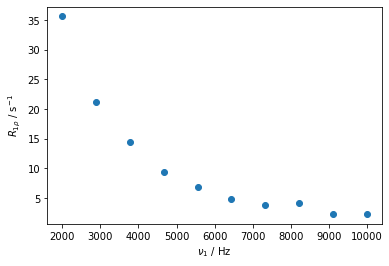

In [118]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
v10=np.linspace(2000,10000,10)
R1p=[]
# For each spin lock field strength we calculate the propagator and determine the relaxation rate
for v1 in v10:
    rho.clear()
    U=R1pU(tc=1e-4,hop_angle=0,DelCS=5,v1=v1)
    R1p.append(rho.extract_decay_rates(U))
R1p = np.array(R1p)
R1p+=np.random.randn(len(R1p))*R1p.min()*.15

fig,ax = plt.subplots()
ax.plot(v10, R1p, marker='o', linestyle='none')
ax.set_xlabel("$\\nu_1$ / Hz")
ax.set_ylabel("$R_{1\\rho}$ / s$^{-1}$")
plt.show()

Below, we introduce a function to calculate $R_{1\rho}$ resulting from chemical exchange, and use it to fit the above dataset.

p1 = 0.19 +- 422.77
dW = 6.58 +- 5963.58 ppm
kex = 9890.29 +- 558205.75 s-1


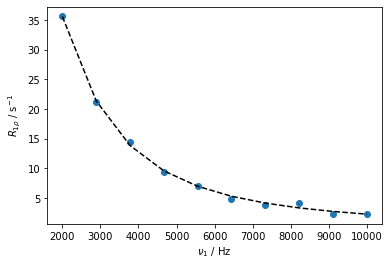

In [119]:
def R1p_ex(v1, p1, DelOmega, kex): # equivalent to R1p_ex above, parameterised for curve fitting.
    p2 = 1 - p1
    Omega1 = -DelOmega*p2
    Omega2 = DelOmega*p1
    Omega=p1*Omega1+p2*Omega2
    DelOmega=Omega1-Omega2
    omega1=2*np.pi*v1
    omega_e=np.sqrt(omega1**2+Omega**2)
    omega_e1=np.sqrt(omega1**2+Omega1**2)
    omega_e2=np.sqrt(omega1**2+Omega2**2)
    sin2Beta=omega1**2/(omega1**2+Omega**2)

    f1=omega_e1**2*omega_e2**2/omega_e**2
    f2=2*kex**2*(p1*omega_e1**2+p2*omega_e2**2)/(omega_e1**2*omega_e2**2+omega_e**2*kex**2)
    R1p=sin2Beta*p1*p2*DelOmega**2*kex/(f1+kex**2-sin2Beta*p1*p2*DelOmega**2*(1+f2))
    return R1p

# We use scipy optimize's curve_fit function to fit the model. If we had experimental uncertainties,
# these could be included using the 'sigma' and 'absolute_sigma' parameters of this function.
popt, pcov = curve_fit(R1p_ex, v10, R1p, p0=[0.2, 5, 1000], bounds=[(0, 0, 0), (0.5, np.inf, np.inf)], maxfev=20000)
perr = np.sqrt(np.diag(pcov)) # take standard deviation as uncertainty from variances in covariance matrix

print("p1 = %0.2f +- %0.2f" % (popt[0], perr[0]))
print("dW = %0.2f +- %0.2f ppm"%(popt[1] / (2*np.pi*60), perr[1] / (2*np.pi*60))) # divide to convert from rad/s to ppm
print("kex = %0.2f +- %0.2f s-1"%(popt[2], perr[2]))

fig,ax = plt.subplots()
ax.plot(v10, R1p, marker='o', linestyle='none')
ax.plot(v10, R1p_ex(v10, *popt), 'k--')
ax.set_xlabel("$\\nu_1$ / Hz")
ax.set_ylabel("$R_{1\\rho}$ / s$^{-1}$")
plt.show()

Huh - odd. It appears that we have a really well fit curve, but the uncertainties in the populations (p1) and chemical shift difference (dW) are massive! Lets try to investigate this - we'll plot the root sum squared residual as a function of these two parameters:

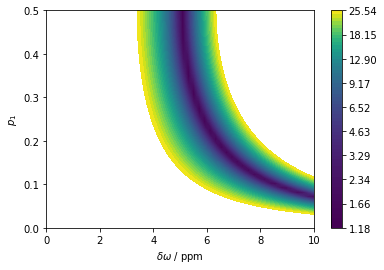

In [122]:
def sqres(dw, p):
    # calculate the root sum squared residual as a function of dW and population
    return np.sqrt(np.sum(np.power(R1p[:,np.newaxis,np.newaxis] - R1p_ex(v10[:,np.newaxis, np.newaxis], p, dw * 2 * np.pi * 60, 1e4), 2), axis=0))

dW = np.linspace(0, 10, 50) # ppm
p1 = np.linspace(0, 0.5, 50)
DW, P1 = np.meshgrid(dW, p1)
residual = sqres(DW, P1)
clevels = np.min(residual) * 1.05**np.arange(64)
fig, ax = plt.subplots()
cb = ax.contourf(DW, P1, residual, levels=clevels)
fig.colorbar(cb)
ax.set_xlabel("$\\delta \\omega$ / ppm")
ax.set_ylabel("$p_{1}$")
plt.show()

**Q:** From the plot above, can you explain why the errors for $p_1$ and $\delta\omega$ are so high?
```{dropdown} Answer
The minimum error is not found at a single point, but rather along a contour, so neither $\delta\omega$, nor $p_1$ can be precisely defined.

This is because our exchange rate is greater than the difference in chemical shift between the exchanging sites, we are in what is termed the 'fast exchange limit'. In this case, the Miloushev-Palmer equation is highly degenerate in populations and chemical shift differences: It is not possible to break the degeneracy in this case. 

But does this always need to be the case? 
```

To understand which timescales we are sensitive to, we can consider the difference in $R_{1\rho}$ at 2 and 10 kHz. If we see a large, measurable difference, we can therefore measure exchange processes with this rate. If not, we are unable to distinguish these.

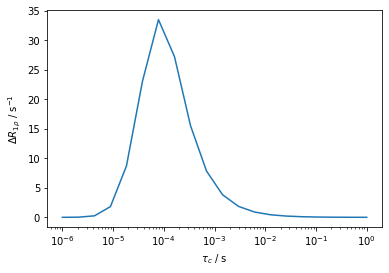

In [123]:
tau_c = np.logspace(-6, 0, 20)
dR1p = []
for tau in tau_c:
    rho.clear()
    U_1kHz = R1pU(tc=tau,hop_angle=0,DelCS=5,v1=2000,gamma=0)
    R1p_1kHz = rho.extract_decay_rates(U_1kHz)
    rho.clear()
    U_10kHz = R1pU(tc=tau,hop_angle=0,DelCS=5,v1=10000,gamma=0)
    R1p_10kHz = rho.extract_decay_rates(U_10kHz)
    dR1p.append(R1p_1kHz - R1p_10kHz)
    
fig, ax = plt.subplots()
ax.plot(tau_c, dR1p)
ax.set_xscale('log')
ax.set_xlabel("$\\tau_c$ / s")
ax.set_ylabel("$\\Delta R_{1\\rho}$ / s$^{-1}$")
plt.show()

As can be seen, because of the limitations of our experiment we are limited to correlation times on the order of 10$^{-5}$ s to 10$^{-3}$ s - these correspond to exchange rates from 1000 s$^{-1}$ to 100,000 s$^{-1}$. Consequently, for $^{15}$N, unless $\delta \omega > 16.7$ ppm, we are in fast exchange and cannot separate populations and chemical shifts. 

As a further issue, because of this limitation it is also not possible for us to know that we are in two site exchange. As a result, we should not fit a two site exchange model. 

What is typically done instead is to assume a single process, and fit a scaling amplitude:

$R_{1\rho} = \frac{\phi_{ex} k_{ex}}{\omega_{1}^{2} + k_{ex}^{2}}$,

where (for two-site exchange), $\phi = p_1 p_2 (\Delta \omega^2)$

phiex = 916941.31 +- 16836.96
kex = 10012.90 +- 406.07 s-1
For p1=0.5, dv=5.08+-0.69


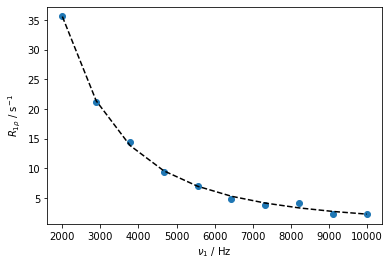

In [127]:
def R1p_ex(v1, phiex, kex):
    omega1=2*np.pi*v1
    Omega = 0 # transmitter offset
    omega_e=np.sqrt(omega1**2+Omega**2)
    sin2Beta=omega1**2/(omega1**2+Omega**2)

    R1p=sin2Beta*phiex*kex/(omega_e**2 + kex**2)
    return R1p

popt, pcov = curve_fit(R1p_ex, v10, R1p, p0=[100, 1000], bounds=[(0, 0), (np.inf, np.inf)], maxfev=20000)
perr = np.sqrt(np.diag(pcov))
print("phiex = %0.2f +- %0.2f" % (popt[0], perr[0]))
print("kex = %0.2f +- %0.2f s-1"%(popt[1], perr[1]))
dv,dve=np.sqrt(np.array([popt[0],perr[0]])*4)/(2*np.pi*60)
print(f"For p1=0.5, dW={dv:.2f}+-{dve:.2f}")

fig,ax = plt.subplots()
ax.plot(v10, R1p, marker='o', linestyle='none')
ax.plot(v10, R1p_ex(v10, *popt), 'k--')
ax.set_xlabel("$\\nu_1$ / Hz")
ax.set_ylabel("$R_{1\\rho}$ / s$^{-1}$")
plt.show()

It appears again that we have a good fit! But let's double check the parameters to ensure this isn't a degenerate fit.

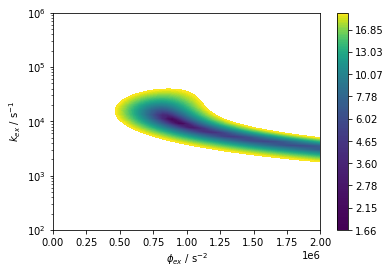

In [132]:
# Appears we have a good fit! But let's check our parameter degeneracy

def sqres(phiex, kex):
    return np.sqrt(np.sum(np.power(R1p[:,np.newaxis,np.newaxis] - R1p_ex(v10[:,np.newaxis, np.newaxis], phiex, kex), 2), axis=0))

phi = np.linspace(0, 2e6, 50)
kex = np.logspace(2, 6, 50)
PHI, KEX = np.meshgrid(phi, kex)
residual = sqres(PHI, KEX)
clevels = np.min(residual) * 1.02**np.arange(128)
fig, ax = plt.subplots()
cb = ax.contourf(PHI, KEX, residual, levels=clevels, cmap='viridis')
ax.set_yscale('log')
fig.colorbar(cb)
ax.set_xlabel("$\\phi_{ex}$ / s$^{-2}$")
ax.set_ylabel("$k_{ex}$ / s$^{-1}$")
plt.show()

Then, the parameter $\phi_{ex}$ becomes well defined, although its interpretation is ambiguous. If we assume two-site exchange, $\phi_{ex}=p_1p_2(\Delta\omega)^2$, we can place a lower bound on $\Delta\omega$, by assuming $p_1=0.5$, but for lower values of $p_1$, $\Delta\omega$ must be larger. Furthermore, it is difficult to know for sure that we have a two-site hopping motion, which further confounds our interpretation of the parameter (but don't despair, a timescale and a lower bound for $\Delta\omega$ is a lot of information, especially if we have this information for multiple residues or another source of dynamics information)